### RNN结构的局限

机器翻译解决的是输入是一串在某种语言中的一句话，输出是目标语言相对应的话的问题，如将德语中的一段话翻译成合适的英语。之前的Neural Machine Translation(一下简称NMT)模型中，通常的配置是encoder-decoder结构，即encoder读取输入的句子将其转换为定长的一个向量，然后decoder再将这个向量翻译成对应的目标语言的文字。

### Attention机制的引入

为了解决这一由长序列到定长向量转化而造成的信息损失的瓶颈，Attention注意力机制被引入了。Attention机制跟人类翻译文章时候的思路有些类似，即将注意力关注于我们翻译部分对应的上下文。同样的，Attention模型中，当我们翻译当前词语时，我们会寻找源语句中相对应的几个词语，并结合之前的已经翻译的部分作出相应的翻译，如下图所示，当我们翻译“knowledge”时，只需将注意力放在源句中“知识”的部分，当翻译“power”时，只需将注意力集中在"力量“。这样，当我们decoder预测目标翻译的时候就可以看到encoder的所有信息，而不仅局限于原来模型中定长的隐藏向量，并且不会丧失长程的信息。

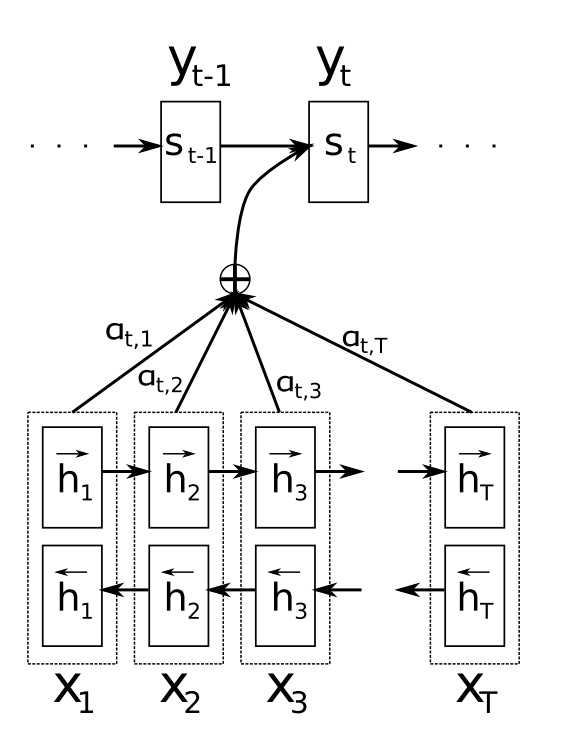


 ## HAN原理

      HAN模型就是分层次的利用注意力机制来构建文本向量表示的方法。

       文本由句子构成，句子由词构成，HAN模型对应这个结构分层的来构建文本向量表达；

       文本中不同句子对文本的主旨影响程度不同，一个句子中不同的词语对句子主旨的影响程度也不同，因此HAN在词语层面和句子层面分别添加了注意力机制；

       分层的注意力机制还有一个好处，可以直观的看出用这个模型构建文本表示时各个句子和单词的重要程度，增强了可解释性。

In [ ]:
# 构建模型
class BiLSTMAttention(object):
    """
    Text CNN 用于文本分类
    """
    def __init__(self, config, wordEmbedding):

        # 定义模型的输入
        self.inputX = tf.placeholder(tf.int32, [None, config.sequenceLength], name="inputX")
        self.inputY = tf.placeholder(tf.float32, [None, 1], name="inputY")
        
        self.dropoutKeepProb = tf.placeholder(tf.float32, name="dropoutKeepProb")
        
        # 定义l2损失
        l2Loss = tf.constant(0.0)
        
        # 词嵌入层
        with tf.name_scope("embedding"):

            # 利用预训练的词向量初始化词嵌入矩阵
            self.W = tf.Variable(tf.cast(wordEmbedding, dtype=tf.float32, name="word2vec") ,name="W")
            # 利用词嵌入矩阵将输入的数据中的词转换成词向量，维度[batch_size, sequence_length, embedding_size]
            self.embeddedWords = tf.nn.embedding_lookup(self.W, self.inputX)
            
        # 定义两层双向LSTM的模型结构
        with tf.name_scope("Bi-LSTM"):
            for idx, hiddenSize in enumerate(config.model.hiddenSizes):
                with tf.name_scope("Bi-LSTM" + str(idx)):
                    # 定义前向LSTM结构
                    lstmFwCell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(num_units=hiddenSize, state_is_tuple=True),
                                                                 output_keep_prob=self.dropoutKeepProb)
                    # 定义反向LSTM结构
                    lstmBwCell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(num_units=hiddenSize, state_is_tuple=True),
                                                                 output_keep_prob=self.dropoutKeepProb)


                    # 采用动态rnn，可以动态的输入序列的长度，若没有输入，则取序列的全长
                    # outputs是一个元祖(output_fw, output_bw)，其中两个元素的维度都是[batch_size, max_time, hidden_size],fw和bw的hidden_size一样
                    # self.current_state 是最终的状态，二元组(state_fw, state_bw)，state_fw=[batch_size, s]，s是一个元祖(h, c)
                    outputs_, self.current_state = tf.nn.bidirectional_dynamic_rnn(lstmFwCell, lstmBwCell, 
                                                                                  self.embeddedWords, dtype=tf.float32,
                                                                                  scope="bi-lstm" + str(idx))
        
                    # 对outputs中的fw和bw的结果拼接 [batch_size, time_step, hidden_size * 2], 传入到下一层Bi-LSTM中
                    self.embeddedWords = tf.concat(outputs_, 2)
                
        # 将最后一层Bi-LSTM输出的结果分割成前向和后向的输出
        outputs = tf.split(self.embeddedWords, 2, -1)
        
        # 在Bi-LSTM+Attention的论文中，将前向和后向的输出相加
        with tf.name_scope("Attention"):
            H = outputs[0] + outputs[1]

            # 得到Attention的输出
            output = self.attention(H)
            outputSize = config.model.hiddenSizes[-1]
        
        # 全连接层的输出
        with tf.name_scope("output"):
            outputW = tf.get_variable(
                "outputW",
                shape=[outputSize, 1],
                initializer=tf.contrib.layers.xavier_initializer())
            
            outputB= tf.Variable(tf.constant(0.1, shape=[1]), name="outputB")
            l2Loss += tf.nn.l2_loss(outputW)
            l2Loss += tf.nn.l2_loss(outputB)
            self.predictions = tf.nn.xw_plus_b(output, outputW, outputB, name="predictions")
            self.binaryPreds = tf.cast(tf.greater_equal(self.predictions, 0.0), tf.float32, name="binaryPreds")
        
        # 计算二元交叉熵损失
        with tf.name_scope("loss"):
            
            losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.predictions, labels=self.inputY)
            self.loss = tf.reduce_mean(losses) + config.model.l2RegLambda * l2Loss
    
    def attention(self, H):
        """
        利用Attention机制得到句子的向量表示
        """
        # 获得最后一层LSTM的神经元数量
        hiddenSize = config.model.hiddenSizes[-1]
        
        # 初始化一个权重向量，是可训练的参数
        W = tf.Variable(tf.random_normal([hiddenSize], stddev=0.1))
        
        # 对Bi-LSTM的输出用激活函数做非线性转换
        M = tf.tanh(H)
        
        # 对W和M做矩阵运算，W=[batch_size, time_step, hidden_size]，计算前做维度转换成[batch_size * time_step, hidden_size]
        # newM = [batch_size, time_step, 1]，每一个时间步的输出由向量转换成一个数字
        newM = tf.matmul(tf.reshape(M, [-1, hiddenSize]), tf.reshape(W, [-1, 1]))
        
        # 对newM做维度转换成[batch_size, time_step]
        restoreM = tf.reshape(newM, [-1, config.sequenceLength])
        
        # 用softmax做归一化处理[batch_size, time_step]
        self.alpha = tf.nn.softmax(restoreM)
        
        # 利用求得的alpha的值对H进行加权求和，用矩阵运算直接操作
        r = tf.matmul(tf.transpose(H, [0, 2, 1]), tf.reshape(self.alpha, [-1, config.sequenceLength, 1]))
        
        # 将三维压缩成二维sequeezeR=[batch_size, hidden_size]
        sequeezeR = tf.squeeze(r)
        
        sentenceRepren = tf.tanh(sequeezeR)
        
        # 对Attention的输出可以做dropout处理
        output = tf.nn.dropout(sentenceRepren, self.dropoutKeepProb)
        
        return output